In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
from tqdm import tqdm
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
config = f"""
execution:
    stage2_exp_id: exp_044
    reg_exp_id: exp_045
    ranker_exp_id: exp_046
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['reg_exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [4]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [5]:
for sid in labels["series_id"].unique():
    df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{sid}.csv")
    print(df["enmo"].max(), df["enmo"].min(), df["enmo"].mean(), df["enmo"].std())
    break

3.3255 0.0 0.03484659715809993 0.07286089582971812


<AxesSubplot: >

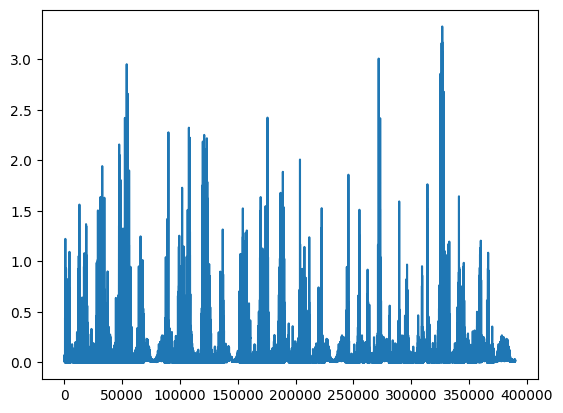

In [6]:
df["enmo"].plot()

In [7]:
train = pd.read_parquet(f'{CFG["dataset"]["competition_dir"]}/train_series.parquet')
train

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [10]:
train[["enmo", "anglez"]].mean()

enmo      0.041315
anglez   -8.810453
dtype: float32

In [11]:
train[["enmo", "anglez"]].std()

enmo       0.101829
anglez    35.521877
dtype: float32

In [ ]:
ENMO_MEAN = 0.041315
ANGLEZ_MEAN = -8.810453
ENMO_STD = 0.101829
ANGLEZ_STD = 35.521877